In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress

from xgcm import Grid
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater
import os

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
# Load Info for Upwelling


#cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})

dic=xr.open_dataset('../processed_data/physics_ds/dic_pac_feb7.nc')
adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt
sw_ocean=cafe_wt['sw_ocean'].copy()
cafe_wt=cafe_wt.chunk('auto').rename({'sw_ocean':'st_ocean'}).interp(st_ocean=dic_cafe.chunk('auto').st_ocean)#.chunk('auto')

# We want to regrid the DIC transport to the 1015 to 1030 kg/m3 in potential density space
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__

    
# THESE ARE THE Depth Integrated DIC Transport Files (mmol/s/cell)
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6

upwelling=(cafe_wt*dic_cafe.chunk('auto')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt*anth_dic_cafe.chunk('auto')*area_m2)#/1e6 # To Sverdrups

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [3]:
# LOAD General DataE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40),)

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [5]:
cluster

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.129:34281,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
dsu=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc')
dsu.sel(lat=-3,method='nearest').tracer.mean()

#up=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_w_tx_density_thickness_test.nc')

<xarray.DataArray 'tracer' ()>
array(-3180968.2, dtype=float32)
Coordinates:
    ensemble  int32 ...
    lat       float64 -2.833

Really feel like I had it this time! Still waaay too low i think.

https://nbviewer.org/github/claireyung/cosima-recipes/blob/master/DocumentedExamples/Binning_transformation_from_z_to_potrho.ipynb

Conservative transformation is designed to preseve the total sum of phi over the Z axis. It presumes that phi is an extensive quantity, i.e. a quantity that is already volume weighted, with respect to the Z axis: for example, units of Kelvins * meters for heat content, rather than just Kelvins. The conservative method requires more input data at the moment. You have to not only specify the coordinates of the cell centers, but also the cell faces (or bounds/boundaries). In xgcm we achieve this by defining the bounding coordinates as the outer axis position. The target theta values are likewise intepreted as cell boundaries in theta-space. In this way, conservative transformation is similar to calculating a histogram.

Is it because units are in mmolC/s/cell rather than m

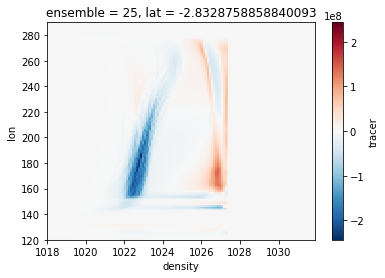

In [14]:
dsu.sel(lat=-3,method='nearest').tracer.mean(dim='time').plot()

In [9]:
#anth_dic_u_tx.interp(lon=cafe_potential_density.lon)

In [10]:
#tracer_density.mean().values

In [15]:
client

<Client: 'tcp://10.0.128.129:34281' processes=8 threads=32, memory=175.12 GiB>

In [16]:
# Density Conversion
density_conversion=True
if density_conversion==True:
    tracers=['anth_dic_u_tx','upwelling'] #'dic_v_tx,# 'anth_dic_v_tx','dic_u_tx',
    #'upwelling','anthupwelling','dic_u_tx','anth_dic_u_tx',
    #tracer_name='dic_u_tx'
    for tracer_name in tracers:
        tracer_interpolate=eval(tracer_name)#.chunk('auto')#eval(tracer_name).chunk('auto')

        if 'u' in tracer_name.split('_'):
            tracer_interpolate=tracer_interpolate.interp(lon=cafe_potential_density.lon)
            
        if 'v' in tracer_name.split('_'):
            print('v')
            tracer_interpolate=tracer_interpolate.interp(lat=cafe_potential_density.lat)

        tracer_interpolate_fix=tracer_interpolate.to_dataset(name=tracer_name).assign_coords({'sw_ocean':sw_ocean})

        tracer_interpolate_fix['density']=cafe_potential_density.chunk('auto')

        density_grid=Grid(tracer_interpolate_fix, coords={'density_grid': {'center':'sw_ocean','outer':'st_ocean'}}, periodic=False)
        #tracer_interpolate_fix['dens_outer'] = density_grid.interp(tracer_interpolate_fix.density, 'density_grid', boundary='extend')
        # Regrid Tracer to the center of the vertical Box.
        tracer_interpolate_fix['tracer'] = density_grid.interp(tracer_interpolate_fix[tracer_name], 'density_grid', boundary='extend')


        theta_target = np.arange(1018, 1032., 0.1)
        tracer_density = density_grid.transform(tracer_interpolate_fix['tracer'].fillna(0),
                                          'density_grid',
                                          theta_target,
                                          method='conservative',
                                          target_data=tracer_interpolate_fix.density.fillna(0))
        print(tracer_density)
        print(f'saving {tracer_name} which is {tracer_density.nbytes/1e9}GB')
        tracer_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density.nc')
        print('saved')
    #tracer_density.rename({'dens_outer':'density'})

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


<xarray.DataArray 'tracer' (time: 731, lat: 140, lon: 170, density: 139)>
dask.array<transpose, shape=(731, 140, 170, 139), dtype=float32, chunksize=(43, 70, 82, 139), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * density   (density) float64 1.018e+03 1.018e+03 ... 1.032e+03 1.032e+03
saving anth_dic_u_tx which is 9.6731768GB
saved
<xarray.DataArray 'tracer' (time: 731, lat: 140, lon: 170, density: 139)>
dask.array<transpose, shape=(731, 140, 170, 139), dtype=float32, chunksize=(43, 70, 82, 139), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


saved


Example
tracer_interpolate=dic_v_tx
tracer_interpolate=tracer_interpolate.interp(lat=cafe_potential_density.lat) #u lon
tracer_interpolate_fix=tracer_interpolate.to_dataset(name=tracer_name).assign_coords({'sw_ocean':sw_ocean})
tracer_interpolate_fix['density']=cafe_potential_density.chunk('auto')
density_grid=Grid(tracer_interpolate_fix, coords={'density_grid': {'center':'sw_ocean','outer':'st_ocean'}}, periodic=False)
tracer_interpolate_fix['tracer'] = density_grid.interp(tracer_interpolate_fix[tracer_name], 'density_grid', boundary='extend')

theta_target = np.arange(1018, 1032., 0.1)
tracer_density = density_grid.transform(tracer_interpolate_fix['tracer'].fillna(0),
                                  'density_grid',
                                  theta_target,
                                  method='conservative',
                                  target_data=tracer_interpolate_fix.density.fillna(0))

In [ ]:
tracer_interpolate_fix[tracer_name]

In [ ]:
tracer_interpolate_fix.density

In [ ]:
tracer_density

In [ ]:
cafe_potential_density

In [ ]:
#'upwelling',
tracers=['anth_dic_u_tx','dic_v_tx','anth_dic_v_tx','upwelling'] #'anthupwelling','dic_u_tx',
#tracers=['anth_dic_u_tx','anth_dic_v_tx']
#tracer_name='dic_u_tx'
for tracer_name in tracers:
    tracer_interpolate=eval(tracer_name).chunk('auto')#eval(tracer_name).chunk('auto')

    if 'u' in tracer_name.split('_')==True:
        tracer_interpolate=tracer_interpolate.interp(lon=cafe_potential_density.lon)
    elif 'v' in tracer_name.split('_')==True:
        tracer_interpolate=tracer_interpolate.interp(lat=cafe_potential_density.lat)

    tracer_interpolate_fix=tracer_interpolate.to_dataset(name=tracer_name).assign_coords({'sw_ocean':sw_ocean})

    tracer_interpolate_fix['density']=cafe_potential_density.chunk('auto')

    density_grid=Grid(tracer_interpolate_fix, coords={'density_grid': {'center':'sw_ocean','outer':'st_ocean'}}, periodic=False)
    #tracer_interpolate_fix['dens_outer'] = density_grid.interp(tracer_interpolate_fix.density, 'density_grid', boundary='fill')
    # Regrid Tracer to the center of the vertical Box.
    tracer_interpolate_fix['tracer'] = density_grid.interp(tracer_interpolate_fix[tracer_name], 'density_grid', boundary='extend')

    #thickness = density_grid.diff(tracer_interpolate_fix.st_ocean, 'density_grid')
    #tracer_interpolate_fix['tracer']=(tracer_interpolate_fix['tracer']*thickness)#.fillna(.)
        
        
    theta_target = np.arange(1018, 1032., 0.1)
    tracer_density = density_grid.transform(tracer_interpolate_fix['tracer'],
                                      'density_grid',
                                      theta_target,
                                      method='conservative',
                                      target_data=tracer_interpolate_fix.density)
    
    print(tracer_density)
    print(f'saving {tracer_name} which is {tracer_density.nbytes/1e9}GB')
    #tracer_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density.nc')
    print('saved')
    
    xxxxx
#tracer_density.rename({'dens_outer':'density'})

In [ ]:
#tracer_name.split('_')

In [ ]:
#tracer_density.mean().values

In [ ]:
#tracer_density.to_netcdf('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density_test.nc')

In [ ]:
#density_grid#tracer_interpolate_fix

In [ ]:
#tracer_interpolate_fix#.tracer

In [ ]:
# Manual version from  Lee et al. (2007) [Lee, M., Nurser, A., Coward, A., and De Cuevas, B. (2007). Eddy advective and diffusive transports of heat and salt in the Southern Ocean. Journal of Physical Oceanography, 37(5):1376–1393.]
ty_trans = tracer_interpolate_fix.tracer.fillna(0).chunk('auto').load()
pot_rho_2 = tracer_interpolate_fix.density.fillna(0).chunk('auto').load()


# choose bins (in this case, default ty_trans_rho pot_rho_2 bins
rho2_bins = theta_target#ty_trans_rho.potrho.values
# set up a zero array to be filled in by the algorithm
ty_trans_binned = np.zeros((len(tracer_interpolate_fix.tracer),len(pot_rho_2.lon),len(pot_rho_2.lat)))


In [ ]:
%%time
# loop over the bins, performing Lee et al. (2007) algorithm
# takes time, faster if ty_trans and pot_rho_2 already loaded
for i in range(len(rho2_bins)-1):
    print(i)
    bin_mask = pot_rho_2.where(pot_rho_2<=rho2_bins[i+1]).where(pot_rho_2>rho2_bins[i])*0+1
    bin_fractions = (rho2_bins[i+1]-pot_rho_2 * bin_mask)/(rho2_bins[i+1]-rho2_bins[i])
    ## bin ty_trans:
    ty_trans_in_lower_bin = (ty_trans * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    ty_trans_binned[i,:,:] += ty_trans_in_lower_bin.fillna(0).values
    del ty_trans_in_lower_bin
    ty_trans_in_upper_bin = (ty_trans * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    ty_trans_binned[i+1,:,:] += ty_trans_in_upper_bin.fillna(0).values
    del ty_trans_in_upper_bin

In [ ]:
#turn np array into xarray
ty_trans_binned_array = xr.DataArray(ty_trans_binned, 
                                               coords = [rho2_bins, pot_rho_2.yt_ocean,pot_rho_2.xt_ocean], 
                                               dims = ['potrho', 'yt_ocean','xt_ocean'], 
                                               name = 'ty_trans_binned')

In [ ]:
# DENSITY CONVERSION
# SAVES IN THE DENSITY FORMAT
from xgcm import Grid
def convert_depth_to_density(dat,var_name='upwelling',depth_var1='sw_ocean',depth_var2='st_ocean',method='conservative',upwelling=False,u=True,thickness_multi=True):
    
    if upwelling==True:
    
        density_grid=Grid(dat, coords={'density_grid': {'center':depth_var1,'outer':depth_var2}}, periodic=False)
    elif upwelling==False:
        if u==True:
            # U is on Lon_x not lon
            tracer_interpolate_fix=dat.rename({'lon':'lon_x'})
            tracer_interpolate_fix=tracer_interpolate_fix.assign_coords({'lat_x':phys_eqpac.lat_x,'lon':phys_eqpac.lon})
            
            density_grid=Grid(tracer_interpolate_fix, coords={'density_grid': {'center':depth_var1,'outer':depth_var2},#}, periodic=False)#,
                                'lat_grid':{'center':'lat','outer':'lat_x'},
                                'lon_grid':{'center':'lon','outer':'lon_x'}}, periodic=False)
            # Need to interp onto lon center.
            tracer_interpolate_fix['tracer'] = density_grid.interp(dat[var_name], 'lat_grid', boundary='fill')
            dat=tracer_interpolate_fix
        elif u==False: # v
            # V is on lat_x not lat
            tracer_interpolate_fix=dat.rename({'lat':'lat_x'})
            tracer_interpolate_fix=tracer_interpolate_fix.assign_coords({'lon':phys_eqpac.lat,'lon_x':phys_eqpac.lon_x})
            
            density_grid=Grid(tracer_interpolate_fix, coords={'density_grid': {'center':'sw_ocean','outer':'st_ocean'},#}, periodic=False)#,
                                    'lat_grid':{'center':'lat','outer':'lat_x'},
                                    'lon_grid':{'center':'lon','outer':'lon_x'}}, periodic=False)
            # Need to interp on lat center
            tracer_interpolate_fix['tracer'] = density_grid.interp(dat[var_name], 'lon_grid', boundary='fill')
            dat=tracer_interpolate_fix
            
    theta_target = np.arange(1018, 1032., 0.1)

    # Regrid Tracer to the center of the vertical Box.
    dat['tracer'] = density_grid.interp(dat[var_name], 'density_grid', boundary='fill')

    if thickness_multi==True:
        thickness = density_grid.diff(dat.st_ocean, 'density_grid')
        dat['tracer']=(dat['tracer']*thickness)#.fillna(.)
    #dat['tracer']=dat['tracer']
    
    print(dat['tracer'])
    print(dat['density'])


    # and transform
    if method=='linear':
        density= density_grid.transform(dat[var_name], 'density_grid', theta_target, target_data=dat['density'],method='linear') #Maybe fix nan if outside range?
    elif method=='conservative':
        density= density_grid.transform(dat['tracer'], 'density_grid', theta_target, target_data=dat['density'],method='conservative')
                             #density=density.rename({'__xarray_dataarray_variable__':'density'})

                                            
    return density
#adic_density.to_netcdf('../processed_data/anth_upwelling_density_grid.nc')

In [ ]:
upwell_fix=upwelling.to_dataset(name='upwelling').assign_coords({'sw_ocean':sw_ocean})
upwell_fix['density']=cafe_potential_density
#upwelling_density=convert_depth_to_density(upwell_fix.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),
#                                           var_name='upwelling',upwelling=True)

anthupwell_fix=anthupwelling.to_dataset(name='anth_upwelling').assign_coords({'sw_ocean':sw_ocean})
anthupwell_fix['density']=cafe_potential_density
                                           
#anthupwelling_density=convert_depth_to_density(anthupwell_fix.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),
#                                               var_name='anth_upwelling',upwelling=True)   

#print(upwelling_density.sel(density=1025,method='nearest').mean().values)
#print('saving')
#upwelling_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/dic_w_tx_density_thickness_test.nc')
#print('Upwelling Saved')
#anthupwelling_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_w_tx_density.nc')
#print('Anth Upwelling Saved')


# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers_density=True
if calculate_horizontal_tracers_density==True:
    names=['dic_u_tx','dic_v_tx','anth_dic_u_tx','anth_dic_v_tx']
    
    for i,tracer_name in enumerate(names):
        if i%2==0: # U tracer
            utrace=True   #tracer_interpolate=eval(tracer_name).chunk('auto').interp(lon=cafe_potential_density.lon) # U is X (lon)
        elif i%2==1: #v tracer
            utrace=False   #tracer_interpolate=eval(tracer_name).chunk('auto').interp(lat=cafe_potential_density.lat) # V is Y (lat)
        tracer_interpolate=eval(tracer_name).chunk('auto')
        tracer_interpolate_fix=tracer_interpolate.to_dataset(name=tracer_name).assign_coords({'sw_ocean':sw_ocean})
        tracer_interpolate_fix['density']=cafe_potential_density.chunk('auto')
        
        tracer_tx_density=convert_depth_to_density(tracer_interpolate_fix.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),
                                                   var_name=tracer_name,u=utrace)

        print(tracer_name)
        print(tracer_tx_density.nbytes/1e9)
        
        print(tracer_tx_density)

        #print(tracer_v_tx_density)
        print('saving')
        tracer_tx_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density_test.nc')
        print(f'{tracer_name}_saved')
        #tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density.nc')
        #print('v saved')

In [ ]:
anth_dic_u_tx

In [ ]:
tracer_name='anth_dic_u_tx'
tracer_interpolate=anth_dic_u_tx.chunk('auto')
tracer_interpolate_fix=tracer_interpolate.to_dataset(name=tracer_name).assign_coords({'sw_ocean':sw_ocean})
tracer_interpolate_fix['density']=cafe_potential_density.chunk('auto')
tracer_interpolate_fix=tracer_interpolate_fix.rename({'lon':'lon_x'})
tracer_interpolate_fix=tracer_interpolate_fix.assign_coords({'lat_x':phys_eqpac.lat_x,'lon':phys_eqpac.lon})
tracer_interpolate_fix

In [ ]:
dgrid=Grid(tracer_interpolate_fix, coords={'density_grid': {'center':'sw_ocean','outer':'st_ocean'}}, periodic=False)#,
                                    #'lat_grid':{'center':'lat_x','outer':'lat'},
                                    #'lon_grid':{'center':'lon','outer':'lon_x'}}, periodic=False)
theta_target = np.arange(1015, 1030., 0.1)
tracer_interpolate_fix['tracer'] = dgrid.interp(tracer_interpolate_fix['anth_dic_u_tx'], 'density_grid', boundary='fill')

thickness = dgrid.diff(tracer_interpolate_fix.st_ocean, 'density_grid')
tracer_interpolate_fix['tracer']=tracer_interpolate_fix['tracer']*thickness

tracer_interpolate_fix['tracer']=tracer_interpolate_fix['tracer'].fillna(0.)
mapped_density= dgrid.transform(tracer_interpolate_fix['tracer'], 'density_grid', theta_target, target_data=tracer_interpolate_fix['density'],method='conservative')

In [ ]:
mapped_density

In [ ]:
mapped_density.sel(lat=-3,method='nearest').mean(dim='time').mean().values#.plot()

In [ ]:
#dgrid.diff(tracer_interpolate_fix.lat, 'lat_grid')

In [ ]:
#dgrid.diff(tracer_interpolate_fix.lat_x, 'lat_grid')

In [ ]:
width_tx=tracer_interpolate_fix['anth_dic_u_tx']*thickness

In [ ]:
width_tx

In [ ]:
tracer_interpolate_fix

In [ ]:
tracer_interpolate_fix

In [ ]:
#cafe_potential_density.mean(dim='time').sel(lat=0,method='nearest').plot() #Make sure values are in range.

In [ ]:
upwell_fix=upwelling.to_dataset(name='upwelling').assign_coords({'sw_ocean':sw_ocean})
upwell_fix['density']=cafe_potential_density
upwelling_density=convert_depth_to_density(upwell_fix.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),
                                           var_name='upwelling',upwelling=True)

anthupwell_fix=anthupwelling.to_dataset(name='anth_upwelling').assign_coords({'sw_ocean':sw_ocean})
anthupwell_fix['density']=cafe_potential_density
                                           
anthupwelling_density=convert_depth_to_density(anthupwell_fix.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),
                                               var_name='anth_upwelling',upwelling=True)   

#print(upwelling_density.sel(density=1025,method='nearest').mean().values)
print('saving')
#upwelling_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/dic_w_tx_density.nc')
print('Upwelling Saved')
#anthupwelling_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_w_tx_density.nc')
print('Anth Upwelling Saved')


# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers_density=True
if calculate_horizontal_tracers_density==True:
    names=['dic_u_tx','dic_v_tx','anth_dic_u_tx','anth_dic_v_tx']
    
    for i,tracer_name in enumerate(names):
        #if i%2==0: # U tracer
        #    tracer_interpolate=eval(tracer_name).chunk('auto').interp(lon=cafe_potential_density.lon) # U is X (lon)
        #elif i%2==1: #v tracer
        #    tracer_interpolate=eval(tracer_name).chunk('auto').interp(lat=cafe_potential_density.lat) # V is Y (lat)
        tracer_interpolate=eval(tracer_name).chunk('auto')
        tracer_interpolate_fix=tracer_interpolate.to_dataset(name=tracer_name).assign_coords({'sw_ocean':sw_ocean})
        tracer_interpolate_fix['density']=cafe_potential_density
        
        tracer_tx_density=convert_depth_to_density(tracer_interpolate_fix.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),
                                                   var_name=tracer_name)

        print(tracer_name)
        print(tracer_tx_density.nbytes/1e9)
        
        print(tracer_tx_density)

        #print(tracer_v_tx_density)
        print('saving')
        tracer_tx_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density_thickness_test.nc')
        print(f'{tracer_name}_saved')
        #tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density.nc')
        #print('v saved')

In [ ]:
# OLOD

In [ ]:
# SAVES IN THE DENSITY FORMAT
def convert_depth_to_density(dat1,dat2,interp_grid=False,method='linear',depth_var='st_ocean'):
    density_grid=Grid(dat1, coords={'density': {'center':depth_var}}, periodic=False)
    theta_target = np.arange(1020, 1030., 0.1)

    # and transform
    density= density_grid.transform(dat1, 'density', theta_target, target_data=dat2,mask_edges=False,method='linear') #Maybe fix nan if outside range?
    density=density.rename({'__xarray_dataarray_variable__':'density'})
    #print(density)
    return density
#adic_density.to_netcdf('../processed_data/anth_upwelling_density_grid.nc')


upwelling_density=convert_depth_to_density(upwelling.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),cafe_potential_density.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}))
anthupwelling_density=convert_depth_to_density(anthupwelling.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),cafe_potential_density.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}))   


print(upwelling_density.sel(density=1025,method='nearest').mean().values)

upwelling_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/dic_w_tx_density.nc')
print('Upwelling Saved')
anthupwelling_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_w_tx_density.nc')
print('Anth Upwelling Saved')


# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers_density=True
if calculate_horizontal_tracers_density==True:
    names=['dic_u_tx','dic_v_tx','anth_dic_u_tx','anth_dic_v_tx']
    
    for i,tracer_name in enumerate(names):
        if i%2==0: # U tracer
            tracer_interpolate=eval(tracer_name).chunk('auto').interp(lon=cafe_potential_density.lon) # U is X (lon)
        elif i%2==1: #v tracer
            tracer_interpolate=eval(tracer_name).chunk('auto').interp(lat=cafe_potential_density.lat) # V is Y (lat)
    
        
        tracer_tx_density=convert_depth_to_density(tracer_interpolate.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}),cafe_potential_density.sel(time=slice('1960','2019-12-31')).chunk({'lat':140,'lon':170}))

        print(tracer_name)
        print(tracer_tx_density.nbytes/1e9)
        
        print(tracer_tx_density)

        #print(tracer_v_tx_density)
        print('saving')
        tracer_tx_density.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density.nc')
        print(f'{tracer_name}_saved')
        #tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{tracer_name}_density.nc')
        #print('v saved')
 

In [ ]:

dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc')
anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc')
dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc')
anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc')
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_w_tx_density.nc')
#anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_w_tx_density.nc')

dic_w_tx_dens.__xarray_dataarray_variable__.sel(density=25,method='nearest').mean(dim='time').plot()


In [ ]:
dic_w_tx_dens.__xarray_dataarray_variable__.sel(density=25,method='nearest').values

In [ ]:
# Get ENSO months
#Calculate ENSO
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')

eqpac
#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [ ]:
enso_months=nina_events

cpd=cafe_potential_density.chunk('auto').sel(time=enso_months).mean(dim='time')
t_ex=anth_dic_v_tx.interp(lat=cafe_potential_density.lat).chunk('auto').sel(time=enso_months).mean(dim='time')
surface=t_ex.where((cpd.chunk('auto')<1023))
upperthermocline=t_ex.where((cpd.chunk('auto')>=1023)&(cpd.chunk('auto')<1024.5))
lowerthermocline=t_ex.where((cpd.chunk('auto')>=1024.5)&(cpd.chunk('auto')<1026.3))
thermostad=t_ex.where((cpd.chunk('auto')>=1026.3))

upperthermocline.sel(lat=-3,method='nearest').plot()
lowerthermocline.sel(lat=-3,method='nearest').plot()